# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


**Описание данных**

Данные находятся в файле `/datasets/autos.csv`.

**Признаки**
* *DateCrawled* — дата скачивания анкеты из базы
* *VehicleType* — тип автомобильного кузова
* *RegistrationYear* — год регистрации автомобиля
* *Gearbox* — тип коробки передач
* *Power* — мощность (л. с.)
* *Model* — модель автомобиля
* *Kilometer* — пробег (км)
* *RegistrationMonth* — месяц регистрации автомобиля
* *FuelType* — тип топлива
* *Brand* — марка автомобиля
* *Repaired* — была машина в ремонте или нет
* *DateCreated* — дата создания анкеты
* *NumberOfPictures* — количество фотографий автомобиля
* *PostalCode* — почтовый индекс владельца анкеты (пользователя)
* *LastSeen* — дата последней активности пользователя

**Целевой признак**

*Price* — цена (евро)

**Этапы работы:**

1. Загрузить данные.
2. Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
3. Подготовить выборки для обучения моделей.
4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.



## Подготовка данных

### Загрузка и изучение данных

Импортируем библиотеки и модули, которые потребуются для выполнения проекта

In [1]:
import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Загрузим и изучим данные

In [2]:
try:
    data = pd.read_csv('datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Для знакомства с данными выведем первые 5 строк датасета, информацию о данных и описательную статистику для количественных данных.

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датасете всего 16 столбцов и 354369 строк, формат данных – `object` (категориальные данные) или `int`(целочисленный). В данных присутствуют пропуски. Переведем значения столбцов  `'DateCrawled'`, `'DateCreated'`, `'LastSeen'` в формат `datetime`.

In [6]:
data[['DateCrawled', 'DateCreated', 'LastSeen']] = data[['DateCrawled', 
                                                       'DateCreated', 
                                                       'LastSeen']].apply(pd.to_datetime)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Описательная статистика показывает проблемы с данными. Например, минимальная цена - 0, минимальная мощность – 0, максимальная мощность – 20000, самый ранний год регистрации – 1000, самый поздний - 9999, есть нулевые значения в столбце `'Month'`, в столбце `'NumberOfPictures'` присутствуют только нулевые значения (что делает его бесполезным). 

Далее проведем **предобработку** данных. Для этого:
   *  удалим дубликаты;
   * обработаем выбросы и аномалии;
   * обработаем аномалии;
   * удалим неинформатиные столбцы.

### Предобработка данных

#### Устранение дубликатов

Посмотрим, есть ли полные дубликаты

In [9]:
data.duplicated().sum()

4

Всего 4 дубликата. Удалим их.

In [10]:
data = data.drop_duplicates().reset_index(drop=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

Дубликаты удалены.

#### Обработка выбросов и аномальных значений

Выше было отмечено, что данные содержат неправдоподобные значения. Рассмотрим распределение значений в столбцах и удалим аномалии. Будем рассматривать аномальные значения только в тех столбцах, которые потребуются для обучения (остальные столбцы удалим в конце подготовки данных).

**Столбец `'Price'`**

<AxesSubplot:>

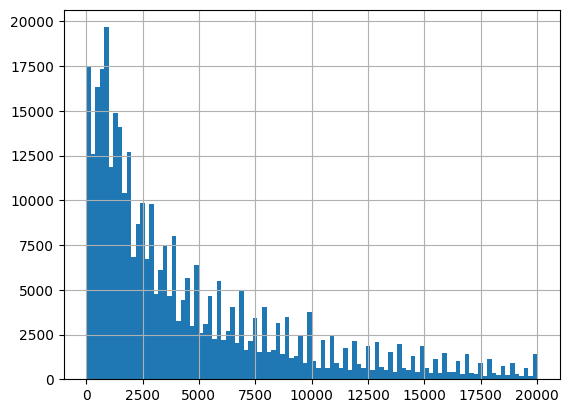

In [12]:
data['Price'].hist(bins=100)

В столбце `'Price'` присутствуют нулевые значения. Чтобы избавиться от аномальных значений цены, отсечем 1% наиболее низких значений.

In [13]:
np.percentile(data['Price'], 1)

0.0

In [14]:
data = data.query('0 < Price')

Дальше увеличивать минимальный порог цены не будем. Можно было бы взять пороговое значение в 100, 300 или 500 евро, но это значение будет произвольным, в то время как мы не знаем обстоятельств и условий продажи: возможно, автомобиль продается на запчасти или утилизацию. При этом на гистограмме нет явных отклонений.

**Столбец `'VehicleType'`**

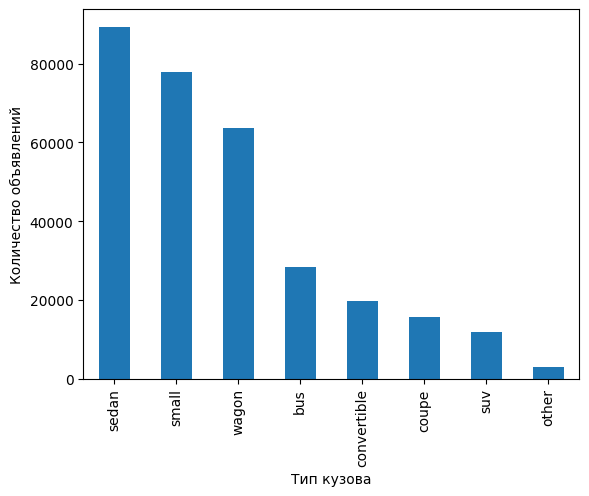

In [15]:
data['VehicleType'].value_counts().plot(kind='bar', xlabel='Тип кузова', ylabel='Количество объявлений');

Седан – наиболее распространенный тип кузова в мире (https://www.autoopt.ru/articles/products/3225024), что согласуется с данными рассматриваемой базы объявлений.

**Столбец `'RegistrationYear'`**

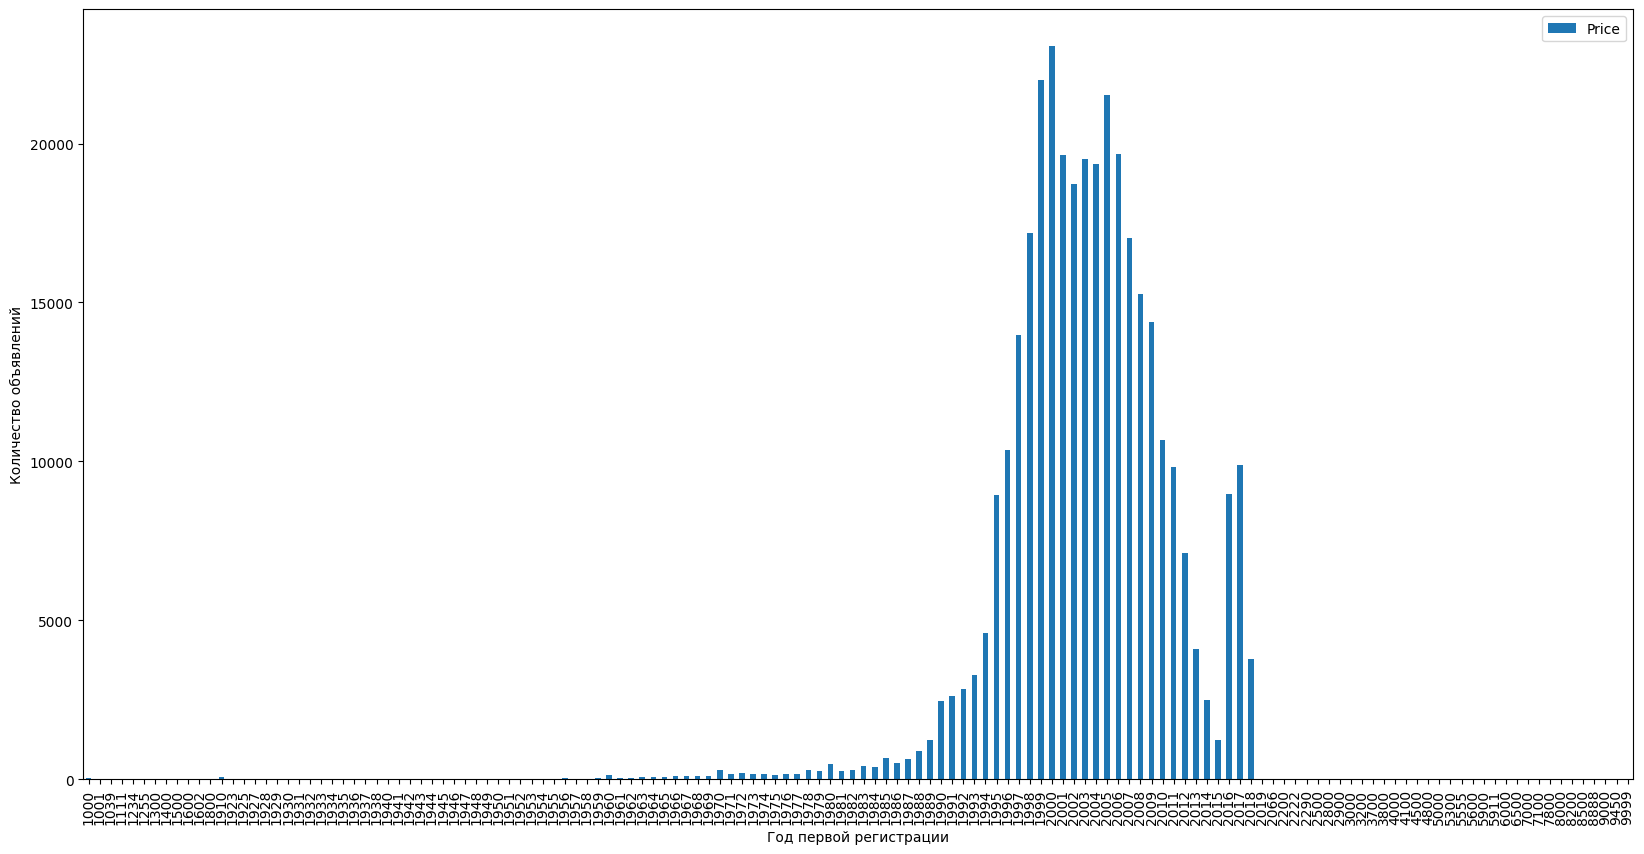

In [16]:
data.pivot_table(index='RegistrationYear',
                          values='Price', 
                          aggfunc='count').plot(kind='bar',
                                                figsize=(20, 10),
                                                xlabel='Год первой регистрации',
                                                ylabel='Количество объявлений')
plt.show()

Минимальный адекватный год регистрации – 1960. Таких объявлений немного, но попадание в базу объявлений старых и раритетных автомобилей с таким годом регистрации не кажется нереалистичным. 

In [17]:
data = data.query('1960 <= RegistrationYear')

Максимальное значение года регистрации не должно быть позже даты создания объявления. 

In [18]:
display(data['DateCreated'].min())
data['DateCreated'].max()

Timestamp('2014-03-10 00:00:00')

Timestamp('2016-04-07 00:00:00')

Обьявления созданы в период с марта 2014 года по апрель 2016 года. Добавим в датасет столбцы 'MonthCreated' и 'YearCreated'. Год регистрации не может быть позже года создания объявления. Если год регистрации и год создания объявления совпадают, месяц регистрации не может быть больше месяца создания объявления.

In [19]:
data['YearCreated'] = data['DateCreated'].dt.year
data['MonthCreated'] = data['DateCreated'].dt.month

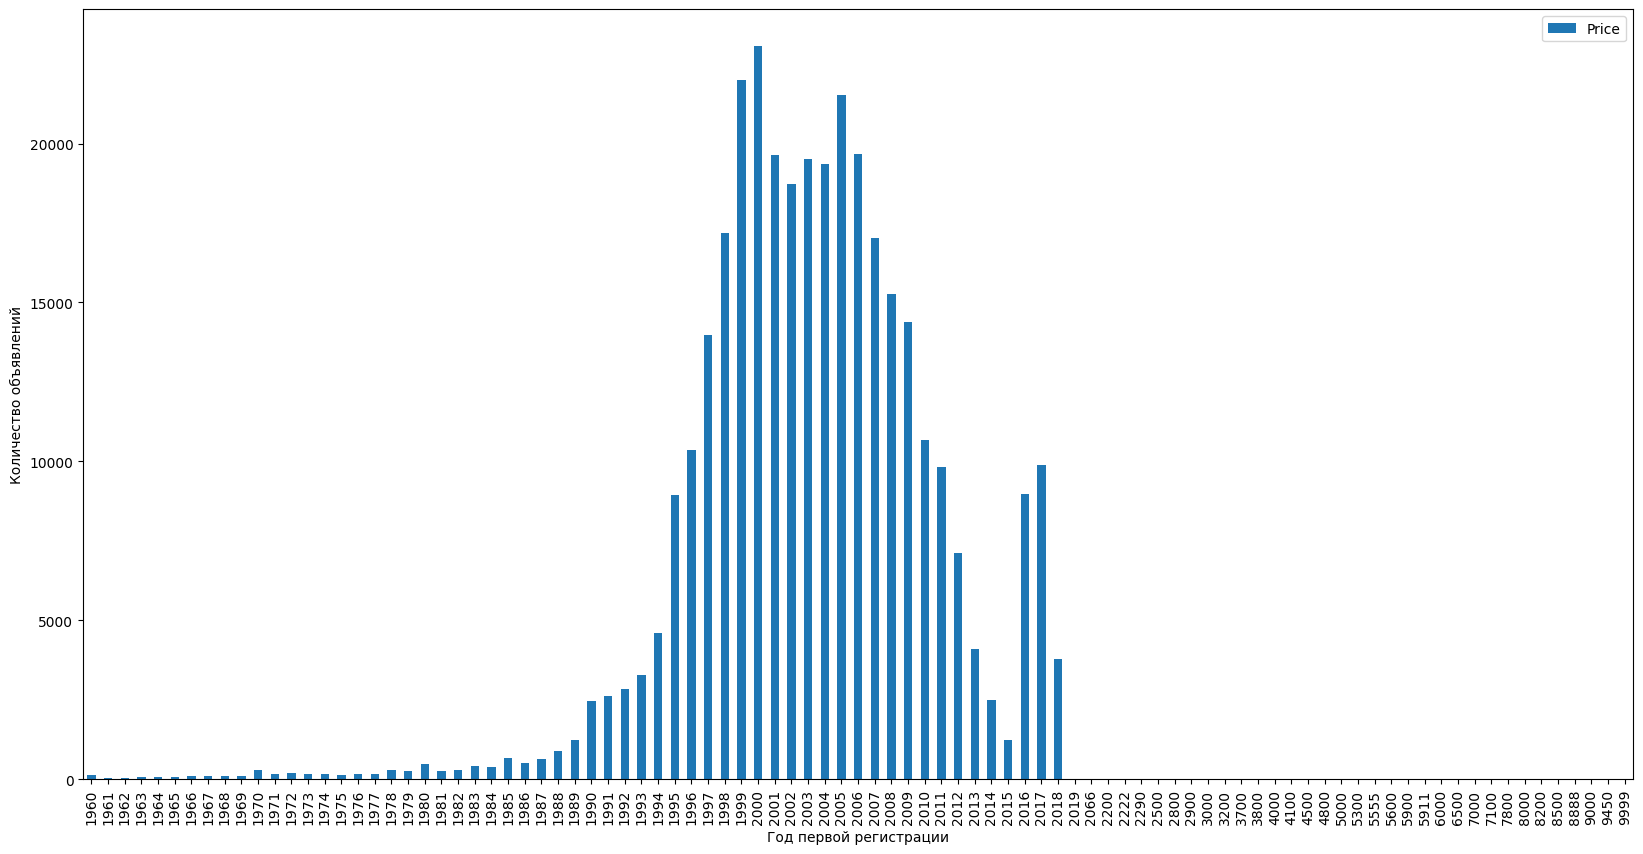

In [20]:
data.pivot_table(index='RegistrationYear',
                          values='Price', 
                          aggfunc='count').plot(kind='bar',
                                                figsize=(20, 10),
                                                xlabel='Год первой регистрации',
                                                ylabel='Количество объявлений')
plt.show()

In [21]:
data = data[(data['RegistrationYear'] < data['YearCreated']) |
                  ((data['RegistrationYear'] == data['YearCreated']) &
                  (data['MonthCreated'] > data['RegistrationMonth']))]

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323856 entries, 0 to 354364
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        323856 non-null  datetime64[ns]
 1   Price              323856 non-null  int64         
 2   VehicleType        309487 non-null  object        
 3   RegistrationYear   323856 non-null  int64         
 4   Gearbox            308834 non-null  object        
 5   Power              323856 non-null  int64         
 6   Model              309036 non-null  object        
 7   Kilometer          323856 non-null  int64         
 8   RegistrationMonth  323856 non-null  int64         
 9   FuelType           301943 non-null  object        
 10  Brand              323856 non-null  object        
 11  Repaired           266393 non-null  object        
 12  DateCreated        323856 non-null  datetime64[ns]
 13  NumberOfPictures   323856 non-null  int64   

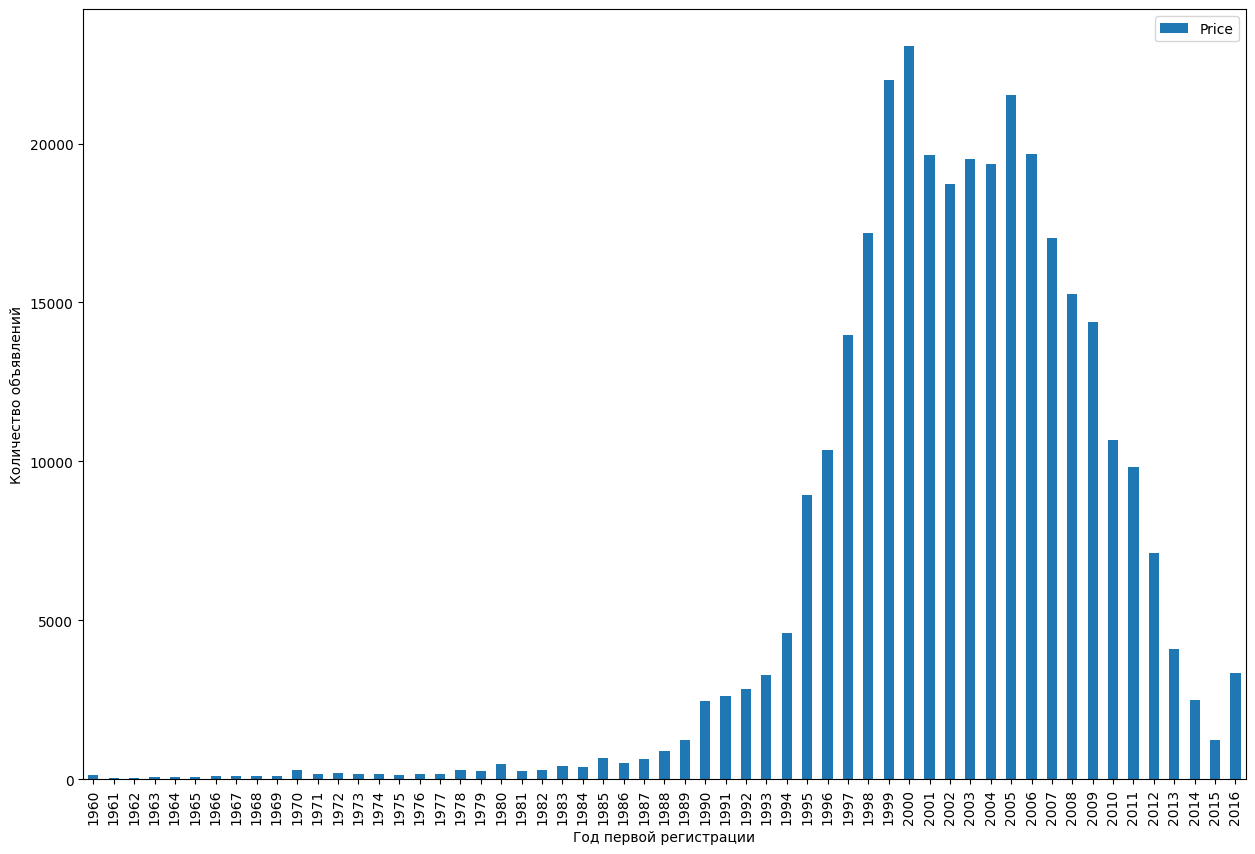

In [23]:
data.pivot_table(index='RegistrationYear',
                          values='Price', 
                          aggfunc='count').plot(kind='bar',
                                                figsize=(15, 10),
                                                xlabel='Год первой регистрации',
                                                ylabel='Количество объявлений')
plt.show()

**Столбец `'Gearbox'`**

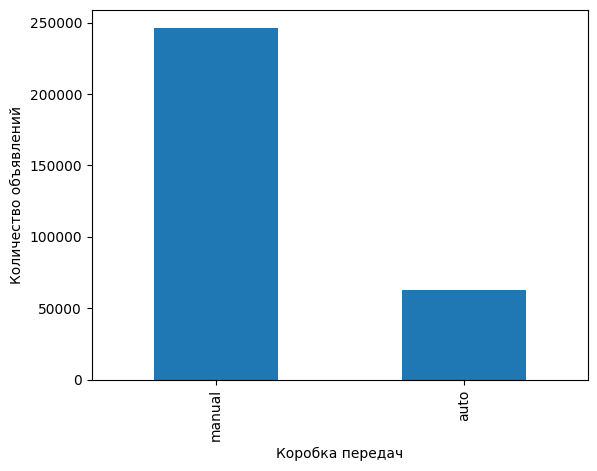

In [24]:
data['Gearbox'].value_counts().plot(kind='bar', xlabel='Коробка передач', ylabel='Количество объявлений');

Количество автомобилей с механической коробкой передач значительно выше, чем с автоматической. Учитывая, что речь идет о подержанных автомобилях, зарегистрированных с 1960 года, данные выглядят правдоподобно. 

**Столбец `'Power'`**

В столбце `'Power'` присутствуют некорректные значения.

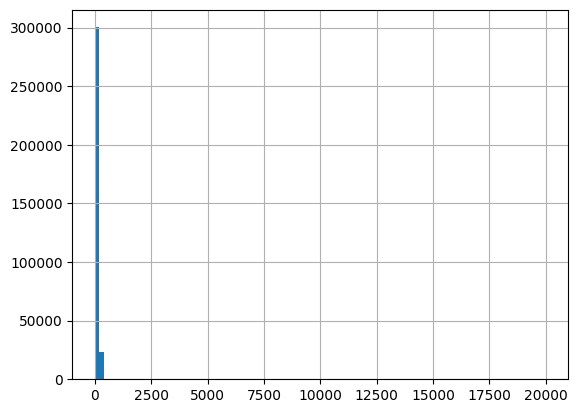

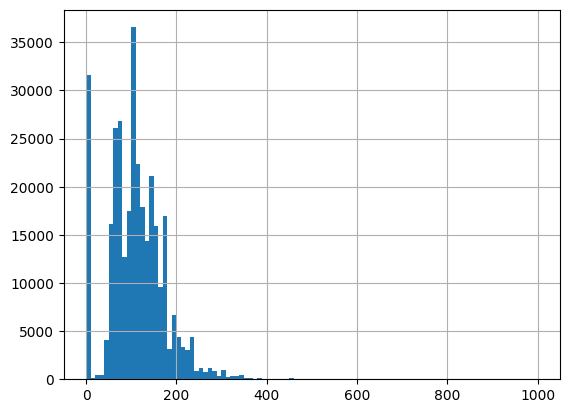

In [25]:
data['Power'].hist(bins=100)
plt.show()

data[(data['Power']<1000)]['Power'].hist(bins=100)
plt.show()

Мощность не может быть нулевой (однако автомобили с очень низкой мощностью существуют: https://automdb.com/min_power). Нулевых значений много, будем считать это ошибкой и удалим соответствующие строки. Также гистограммы показывают, что значения выше 400 л.с. также могут считаться выбросами.

In [26]:
data = data.query('1 <= Power <= 400')

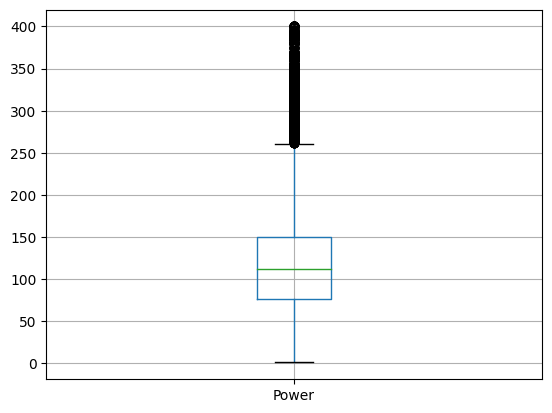

In [27]:
data.boxplot('Power');

**Столбец `'Kilometer'`**

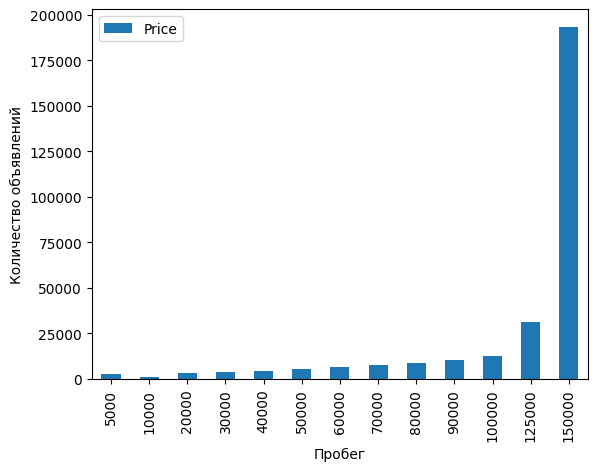

In [28]:
data.pivot_table(index='Kilometer',
                          values='Price', 
                          aggfunc='count').plot(kind='bar',
                                                xlabel='Пробег',
                                                ylabel='Количество объявлений');

Больше всего автомобилей с пробегом 150000 км. Удивительно, что нет объявлений, превышающих данное значение. 

**Столбец `'FuelType'`**

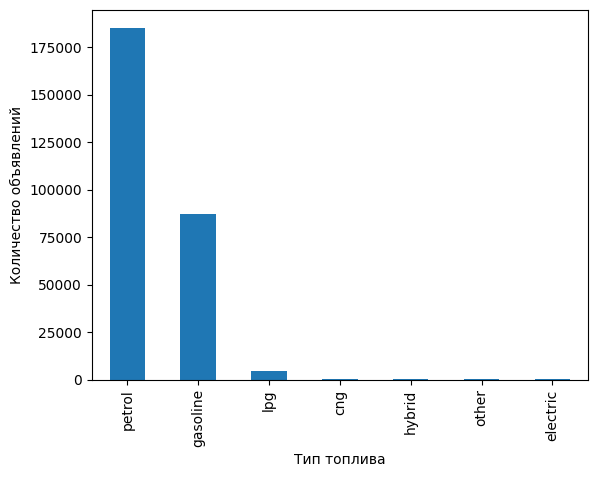

In [29]:
data['FuelType'].value_counts().plot(kind='bar', xlabel='Тип топлива', ylabel='Количество объявлений');

Больше всего автомобилей с типами топлива 'petrol' и 'gasoline'. Интересно, что оба обозначают бензин: 'gasoline' - североамериканский вариант английского языка, 'petrol' - международный вариант (https://en.wikipedia.org/wiki/Gasoline). Объединим эти варианты под названием 'petrol' как более распространенного.

In [30]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')

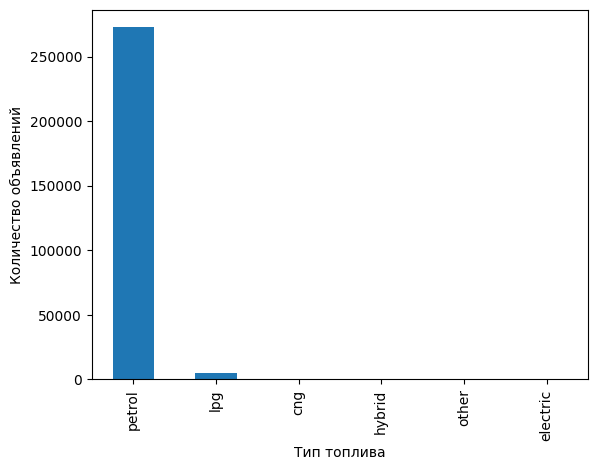

In [31]:
data['FuelType'].value_counts().plot(kind='bar', xlabel='Тип топлива', ylabel='Количество объявлений');

**Столбец `'Brand'`**

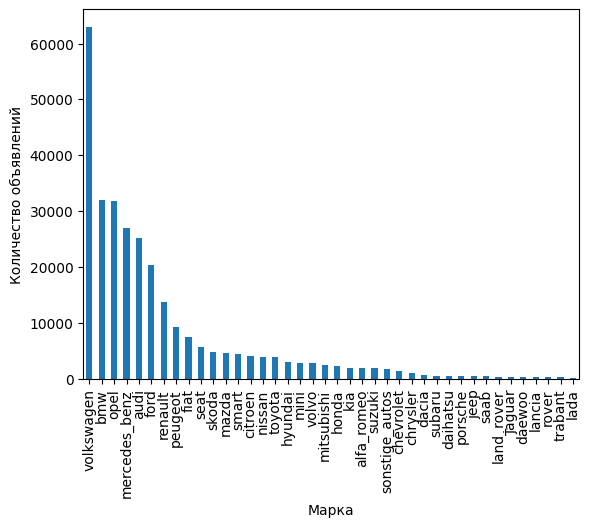

In [32]:
data['Brand'].value_counts().plot(kind='bar', xlabel='Марка', ylabel='Количество объявлений');

Больше всего автомобилей марки "Volkswagen". Это согласуется, например, с историческими данными о продажах автомобилей в Европе, где "Volkswagen Golf" почти каждый год занимает первое место по продажам (https://clck.ru/FgQEq)

Значения остальных столбцов либо нерелевантны, либо не подлежат обработке на предмет аномалий.

#### Обработка пропусков

Определим доли пропусков в разных столбцах.

In [33]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.023460
RegistrationYear     0.000000
Gearbox              0.017627
Power                0.000000
Model                0.036386
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.047039
Brand                0.000000
Repaired             0.141255
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
YearCreated          0.000000
MonthCreated         0.000000
dtype: float64

Пять столбцов содержат пропуски: `'VehicleType'`, `'Gearbox'`, `'Model'`, `'FuelType'`, `'Repaired'`.

Доли пропусков в столбцах `'VehicleType'`, `'Gearbox'`, `'Model'`, `'FuelType'` невелики. Их можно безболезненно удалить.

In [34]:
data = data.dropna(subset=['VehicleType', 
                           'Gearbox', 
                           'Model', 
                           'FuelType'])

Пропуски в столбце `'Repaired'` заменим на `'unknown'`.

In [35]:
data['Repaired'] = data['Repaired'].fillna('unknown')

In [36]:
data.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
YearCreated          0.0
MonthCreated         0.0
dtype: float64

Пропуски устранены.

### Удаление лишних столбцов

Данные в столбцах `'DateCreated'`, `'DateCrawled'`, `'LastSeen'` отображают дату создания анкеты, дату скачивания анкеты из базы и дату последней активности пользователя. Столбец `'PostalCode'` показывает почтовый индекс пользователя. Эти данные не являются признаками и не потребуются при обучении. Также сложно придумать, как месяц первой регистрации (`'RegistrationMonth'`) может влиять на стоимость подержанного автомобиля. В столбце `'NumberOfPictures'` присутствуют только нулевые значения, это делает его неинформативным. Столбцы `'MonthCreated'` и `'YearCreated'` были добавлены для текущих задач и также нерелевантны для обучения. Удалим указанные столбцы.

In [37]:
data_relevant = data[['Price',
                      'VehicleType', 
                      'RegistrationYear',
                      'Gearbox', 
                      'Power',
                      'Model',
                      'Kilometer',
                      'FuelType',
                      'Brand',
                      'Repaired']]

In [38]:
data_relevant = data_relevant.reset_index(drop=True)
data_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263166 entries, 0 to 263165
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             263166 non-null  int64 
 1   VehicleType       263166 non-null  object
 2   RegistrationYear  263166 non-null  int64 
 3   Gearbox           263166 non-null  object
 4   Power             263166 non-null  int64 
 5   Model             263166 non-null  object
 6   Kilometer         263166 non-null  int64 
 7   FuelType          263166 non-null  object
 8   Brand             263166 non-null  object
 9   Repaired          263166 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.1+ MB


**Выводы по шагу 1**

* Данные загружены и изучены.
* Обработаны аномальные значения и выбросы в столбцах `'Price'`, `'RegistrationYear'`, `'Power'`, `'FuelType'`. 
* Обработаны пропуски в столбцах `'VehicleType'`, `'Gearbox'`, `'Model'`, `'FuelType'`, `'Repaired'`.
* Определены релевантные для обучения признаки.

## Обучение  и анализ моделей

Ниже проанилизаруем показатели следующих моделей:

* Дерево решений (DecisionTreeRegressor)
* Случайный лес (RandomForestRegressor)
* CatBoostRerressor
* LGBMRegressor
* Линейная регрессия (LinearRegression)

При выборе модели нас интересуют следующие параметры: 
* качество предсказания (используемая метрика – RMSE);
* время обучения модели;
* время предсказания модели.

Модель с наилучшими параметрами следует проверить на тестовой выборке.

Определим значения интересующих нас параметров, обучив модели на тренировочной выборке и определив их качество на валидационной выборке. Подборем гипараметры лучшей модели при помощи цикла. 

### Подготовка выборок

#### Разделение на выборки

Разделим данные на признаки и целевой признак.

In [39]:
target = data_relevant['Price']
features = data_relevant.drop('Price', axis=1)

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.

In [40]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

# выведем на экран размеры таблиц, которые хранятся в переменных
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(157899, 9)
(157899,)
(52634, 9)
(52634,)
(52633, 9)
(52633,)


Для экономии памяти удалим переменные `features` и `target` которая нам далее не потребуется.

In [41]:
del features
del target

#### Преобразование признаков

Признаки в столбцах `'VehicleType'`, `'Gearbox'`, `'Model'`, `'FuelType'`, `'Brand'`, `'Repaired'` – категориальные.
Преобразуем данные при помощи техники прямого кодирования (`One-Hot Encoding`) и порядкового кодирования (`OrdinalEncoder()`). Первое лучше подходит для линейных моделей, второе – для деревьев и бустингов.

##### Порядковое кодирование

In [42]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)
oe_features_train = features_train.copy()
oe_features_valid = features_valid.copy()
oe_features_test = features_test.copy()
oe_features_train[categorical] = encoder.fit_transform(features_train[categorical])
oe_features_valid[categorical] = encoder.transform(features_valid[categorical])
oe_features_test[categorical] = encoder.transform(features_test[categorical])

In [43]:
display(oe_features_train.shape)
display(oe_features_valid.shape)
oe_features_test.shape

(157899, 9)

(52634, 9)

(52633, 9)

##### Прямое кодирование

In [44]:
def get_ohe(data):
    temp_data = pd.DataFrame(data=encoder_ohe.transform(data[['VehicleType', 'Gearbox', 'Model', 
                                                              'FuelType', 'Brand', 'Repaired']]), 
                             columns=encoder_ohe.get_feature_names_out())
    data.drop(columns=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], axis=1, inplace=True)
    data = pd.concat([data.reset_index(drop=True), temp_data], axis=1)
    return data

In [45]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[categorical])

ohe_features_train = get_ohe(features_train)
ohe_features_valid = get_ohe(features_valid)
ohe_features_test = get_ohe(features_test)

In [46]:
display(ohe_features_train.shape)
display(ohe_features_valid.shape)
ohe_features_test.shape

(157899, 310)

(52634, 310)

(52633, 310)

*Масштабирование признаков*

Масштабируем преобразованные OHE признаки методом стандартизации данных.

In [47]:
numeric = ohe_features_train.columns
scaler = StandardScaler()
ohe_features_train[numeric] = scaler.fit_transform(ohe_features_train[numeric])
ohe_features_valid[numeric] = scaler.transform(ohe_features_valid[numeric])
ohe_features_test[numeric] = scaler.transform(ohe_features_test[numeric])

Исходная тренировочная выборка нам далее не потребуется.

In [48]:
del features_train

### Обучение моделей

Создадим пустые списки, куда будем добавлять значения для будущей сравнительной таблицы.

In [49]:
best_rmse = []
best_model_fit_time = []
best_model_score_time = []

In [50]:
def list_append(best_result, best_model_time_fit, best_model_time_predict):
    best_rmse.append(best_result)
    best_model_fit_time.append(best_model_time_fit)
    best_model_score_time.append(best_model_time_predict)

#### Дерево решений

In [51]:
best_model_dt = None
best_result_dt = 10000
for depth in range(1, 20):
    for samples_leaf in range(1,20):
        model_dt = DecisionTreeRegressor(random_state=12345, max_depth=depth,
                                          min_samples_leaf=samples_leaf)
        
        time_start_fit = time.time()
        model_dt.fit(oe_features_train, target_train)
        time_end_fit = time.time()
        
        time_start_predict = time.time()
        predictions_valid = model_dt.predict(oe_features_valid)
        time_end_predict = time.time()
        
        result_dt = mean_squared_error(target_valid, predictions_valid) ** 0.5
        if result_dt < best_result_dt:
            best_model_dt = model_dt
            best_result_dt = result_dt
            best_depth = depth
            best_samples_leaf=samples_leaf
            best_model_time_fit_dt = time_end_fit - time_start_fit
            best_model_time_predict_dt = time_end_predict - time_start_predict
           
            
print("Значение RMSE наилучшей модели на валидационной выборке:", best_result_dt)
print("max_depth:", best_depth)
print("min_samples_leaf:", best_samples_leaf)
print("Время обучения:", best_model_time_fit_dt)
print("Время предсказания:", best_model_time_predict_dt)

Значение RMSE наилучшей модели на валидационной выборке: 1748.5991967464493
max_depth: 19
min_samples_leaf: 6
Время обучения: 0.2907707691192627
Время предсказания: 0.009106874465942383


In [52]:
list_append(best_result_dt, best_model_time_fit_dt, best_model_time_predict_dt)

#### Случайный лес

In [53]:
best_model_rf = None
best_result_rf = 10000
for est in range(10, 101, 10): 
    for depth in range(1, 21, 5):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        
        time_start_fit = time.time()
        model_rf.fit(oe_features_train, target_train)
        time_end_fit = time.time()
        
        time_start_predict = time.time()
        predictions_valid = model_rf.predict(oe_features_valid)
        time_end_predict = time.time()
        
        result_rf = mean_squared_error(target_valid, predictions_valid) ** 0.5
        if result_rf < best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result_rf
            best_est = est
            best_depth = depth
            best_model_time_fit_rf = time_end_fit - time_start_fit
            best_model_time_predict_rf = time_end_predict - time_start_predict
            
            
print("Значение RMSE наилучшей модели на валидационной выборке:", best_result_rf)
print("max_depth:", best_depth)
print("n_estimators:", best_est)
print("Время обучения:", best_model_time_fit_rf)
print("Время предсказания:", best_model_time_predict_rf)

Значение RMSE наилучшей модели на валидационной выборке: 1607.7889306098346
max_depth: 16
n_estimators: 100
Время обучения: 20.521545886993408
Время предсказания: 0.7650539875030518


In [54]:
list_append(best_result_rf, best_model_time_fit_rf, best_model_time_predict_rf)

#### CatBoostRegressor

In [55]:
best_model_cb = None
best_result_cb = 10000 
for depth in range(1, 5):
    for rate in [.1, .3, .5]:
        for iters in range(10, 101, 10):
            model_cb = CatBoostRegressor(random_state=12345, max_depth=depth, learning_rate=rate,
                                             iterations=iters, verbose=False)
        
            time_start_fit = time.time()
            model_cb.fit(oe_features_train, target_train)
            time_end_fit = time.time()
        
            time_start_predict = time.time()
            predictions_valid = model_cb.predict(oe_features_valid)
            time_end_predict = time.time()
        
            result_cb = mean_squared_error(target_valid, predictions_valid) ** 0.5
            if result_cb < best_result_cb:
                best_model_cb = model_cb
                best_result_cb = result_cb
                best_depth = depth
                best_rate = rate
                best_iters = iters
                best_model_time_fit_cb = time_end_fit - time_start_fit
                best_model_time_predict_cb = time_end_predict - time_start_predict
    


print("Значение RMSE наилучшей модели на валидационной выборке:", best_result_cb)
print("max_depth:", best_depth)
print("learning_rate:", best_rate)
print("iterations:", best_iters)
print("Время обучения:", best_model_time_fit_cb)
print("Время предсказания:", best_model_time_predict_cb)

Значение RMSE наилучшей модели на валидационной выборке: 1718.5117525420899
max_depth: 4
learning_rate: 0.5
iterations: 100
Время обучения: 0.514868974685669
Время предсказания: 0.003543853759765625


In [56]:
list_append(best_result_cb, best_model_time_fit_cb, best_model_time_predict_cb)

#### LGBMRegressor

In [57]:
best_model_gbm = None
best_result_gbm = 10000 
for depth in range(1, 5):
    for rate in [.1, .3, .5]:
        for est in range(10, 101, 10):
            model_gbm = LGBMRegressor(random_state=12345, max_depth=depth, learning_rate=rate,
                                             n_estimators=est, verbose=-1)
        
            time_start_fit = time.time()
            model_gbm.fit(oe_features_train, target_train)
            time_end_fit = time.time()
        
            time_start_predict = time.time()
            predictions_valid = model_gbm.predict(oe_features_valid)
            time_end_predict = time.time()
        
            result_gbm = mean_squared_error(target_valid, predictions_valid) ** 0.5
            if result_gbm < best_result_gbm:
                best_model_gbm = model_gbm
                best_result_gbm = result_gbm
                best_depth = depth
                best_rate = rate
                best_est = est
                best_model_time_fit_gbm = time_end_fit - time_start_fit
                best_model_time_predict_gbm = time_end_predict - time_start_predict

print("Значение RMSE наилучшей модели на валидационной выборке:", best_result_gbm)
print("max_depth:", best_depth)
print("learning_rate:", best_rate)
print("n_estimators:", best_est)
print("Время обучения:", best_model_time_fit_gbm)
print("Время предсказания:", best_model_time_predict_gbm)

Значение RMSE наилучшей модели на валидационной выборке: 1683.4774838300405
max_depth: 4
learning_rate: 0.5
n_estimators: 100
Время обучения: 0.2717931270599365
Время предсказания: 0.03516817092895508


In [58]:
list_append(best_result_gbm, best_model_time_fit_gbm, best_model_time_predict_gbm)

#### Линейная регрессия

In [59]:
best_model_lr = None
best_result_lr = 10000 
for fit_intercept in [True, False]:
    for copy_X in [True, False]:
        model_lr = LinearRegression(fit_intercept=fit_intercept, copy_X=copy_X)
        
        time_start_fit = time.time()
        model_lr.fit(ohe_features_train, target_train)
        time_end_fit = time.time()
        
        time_start_predict = time.time()
        predictions_valid = model_lr.predict(ohe_features_valid)
        time_end_predict = time.time()
        
        result_lr = mean_squared_error(target_valid, predictions_valid) ** 0.5
        if result_lr < best_result_lr:
            best_model_lr = model_lr
            best_result_lr = result_lr
            best_fit_intercept = fit_intercept
            best_copy_X = copy_X
            best_model_time_fit_lr = time_end_fit - time_start_fit
            best_model_time_predict_lr = time_end_predict - time_start_predict

print("Значение RMSE наилучшей модели на валидационной выборке:", best_result_lr)
print("fit_intercept:", best_fit_intercept)
print("copy_X:", best_copy_X)
print("Время обучения:", best_model_time_fit_lr)
print("Время предсказания:", best_model_time_predict_lr)

Значение RMSE наилучшей модели на валидационной выборке: 2544.155482547931
fit_intercept: True
copy_X: True
Время обучения: 8.21074891090393
Время предсказания: 0.12938404083251953


In [60]:
list_append(best_result_lr, best_model_time_fit_lr, best_model_time_predict_lr)

### Анализ результатов

Обобщим результаты в таблице

In [61]:
models_compared_valid = pd.DataFrame(
    {
        'модель':['DecisionTreeRegressor',
                  'RandomForestRegressor',
                  'CatBoostRegressor',
                  'LGBMRegressor', 
                  'LinearRegression'],
        'лучшая RMSE': best_rmse,
        'время обучения лучшей модели': best_model_fit_time,
        'время предсказания лучшей модели': best_model_score_time
    }
)

models_compared_valid

,модель,лучшая RMSE,время обучения лучшей модели,время предсказания лучшей модели
0,DecisionTreeRegressor,1748.599197,0.290771,0.009107
1,RandomForestRegressor,1607.788931,20.521546,0.765054
2,CatBoostRegressor,1718.511753,0.514869,0.003544
3,LGBMRegressor,1683.477484,0.271793,0.035168
4,LinearRegression,2544.155483,8.210749,0.129384


Худший результат на на валидационной выборке по качеству показывает линейная регрессия, обученная на признаках, преобразованных OHE. Наилучшее значение RMSE показывает случайный лес, однако эта модель проказывает очень невысокую скорость. Следующая лучшая по качеству модель – `LGBMRegressor`, также она быстрее всего обучается, но по показателю скорости предсказаний уступает дереву решений и  `CatBoostRegressor`. Таким образом, лучший результат по совокупности качества и скорости показывает `LGBMRegressor`.

### Проверка лучшей модели на тестовой выборке 

Проверим работу лучшей модели на тестовой выборке. Сделаем предсказания и определим значение метрики RMSE.

In [62]:
best_model_gbm

LGBMRegressor(learning_rate=0.5, max_depth=4, random_state=12345, verbose=-1)

In [63]:
%%time
model_gbm = LGBMRegressor(learning_rate=0.5, max_depth=4, random_state=12345, verbose=-1)
model_gbm.fit(oe_features_train, target_train)

CPU times: user 1.91 s, sys: 584 ms, total: 2.5 s
Wall time: 397 ms


LGBMRegressor(learning_rate=0.5, max_depth=4, random_state=12345, verbose=-1)

In [64]:
%%time
predictions_model_test = model_gbm.predict(oe_features_test)

CPU times: user 279 ms, sys: 23.9 ms, total: 303 ms
Wall time: 52 ms


In [65]:
mse = mean_squared_error(target_test, predictions_model_test)
print("RMSE =", mse ** 0.5)

RMSE = 1643.4504105875847


**Вывод:** 

Лучшие результаты на валидационной выборке показывает модель `LGBMRegressor` c гиперпараметрами: `learning_rate=0.5, max_depth=4`. Качество модели проверено на тестовой выборке: значение метрики RMSE не сильно отличается от полученного на валидационной выборке, скорость обучения и предсказания также остаются высокими (и того же порядка).

## Итоги

На основании имеющихся в рапоряжении данных о технических характеристиках, комплектациях и ценах для сервиса по продаже автомобилей с пробегом «Не бит, не крашен» была построена модель для определения стоимости. В ходе работы были выполнены следующие действия:

* данные загружены;
* данные изучены, проведена предобработка данных (обработаны пропуски и аномальные значения, удалены неинформативные столбцы);
* подготовлены выборки для обучения моделей: данные разделены на выборки, категориальные признаки закодированы.
* обучены модели: `DecisionTreeRegressor`, `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor`, `LinearRegression`, для каждой подобраны гиперпараметры для определения лучшей модели;
* проанализированы время обучения, время предсказания и качество моделей.
* в соответствии с критериями заказчика выбрана лучшая модель, проверено её качество на тестовой выборке.

**Общий вывод**: 
Наилучший результат по совокупности качества (метрика RMSE) и скорости обучения и предсказания показывает модель `LGBMRegressor` c гиперпараметрами: `learning_rate=0.5, max_depth=4`. Качество модели проверено на тестовой выборке.